In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression 
from sklearn.utils.fixes import loguniform

import scipy.stats as stats

from panel_utils import *

In [3]:
df = pd.read_csv("../_data/panelbigcap.csv", index_col="Date")
df = df.loc[df.index <= "2019.12.31"]
scale_interact_sort(df=df, micro_cols=micro_cols, macro_cols=macro_cols, interact=False)
df = df.round(4)

In [2]:
%store -r df

In [3]:
train = df.loc[df.index <= "2009.12.31"]
test = df.loc[df.index > "2009.12.31"]

train.shape, test.shape

((235787, 58), (162912, 58))

In [15]:
bestparams = []
predictions = []
naive_predictions = []
train_end_dates = []

naive_mean = DummyRegressor(strategy="mean")

for i in np.arange(2009,2019,1):
    train_realtime = df.loc[pd.to_datetime(df.index).year <= i]
    test_realtime = df.loc[(pd.to_datetime(df.index).year > i) & (pd.to_datetime(df.index).year < i+2)]
    
    X_train, y_train = train_realtime.drop(["EXCESS_RETURN_T+1"], axis=1), train_realtime["EXCESS_RETURN_T+1"]
    X_test, y_test = test_realtime.drop(["EXCESS_RETURN_T+1"], axis=1), test_realtime["EXCESS_RETURN_T+1"]
    
    pipeline = Pipeline([
    ("regressor", Ridge(fit_intercept = False, positive=True))
    ])

    param_grid = {
    "regressor__alpha": stats.uniform(0.1,10000),
    }
    
    grid_search = RandomizedSearchCV(
        estimator = pipeline,
        param_distributions = param_grid,
        scoring = "neg_mean_squared_error",
        refit = "neg_mean_squared_error",
        cv = holdout_cv(X_train, n_test = 4),
        n_iter=500,
        n_jobs = -1,
    )

    grid_search.fit(X_train, y_train)
    naive_mean.fit(X_train, y_train)

    predictions.extend(grid_search.predict(X_test).tolist())
    naive_predictions.extend(naive_mean.predict(X_test).tolist())
    bestparams.append(grid_search.best_params_)
    train_end_dates.append(pd.to_datetime(train_realtime.index[-1]).strftime('%Y-%m-%d'))
    
    print("train end",i)
    print("val MSE",grid_search.best_score_)

train end 2009
val MSE -0.01845898258670394
train end 2010
val MSE -0.01919842537914061
train end 2011
val MSE -0.019671856772786715
train end 2012
val MSE -0.01487249853279875
train end 2013
val MSE -0.009387249952822831
train end 2014
val MSE -0.008438331359262408
train end 2015
val MSE -0.008213394447469897
train end 2016
val MSE -0.008991367870897632
train end 2017
val MSE -0.008762423389177506
train end 2018
val MSE -0.009739422249172415


In [16]:
print("zeroOOSR2", modOOSR2(test["EXCESS_RETURN_T+1"].values, np.array(predictions)))
print("meanOOSR2: ", OOSR2(
    test["EXCESS_RETURN_T+1"].values, 
    np.array(predictions), 
    np.array(naive_predictions)
))

zeroOOSR2 0.01766924050273122
meanOOSR2:  -0.001198672446321991


[]

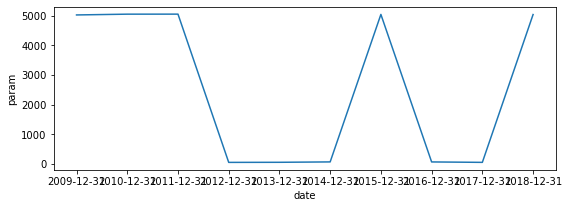

In [14]:
alphalist = []

for paramdict in bestparams:
    alphalist.append( paramdict['regressor__alpha'])
    
fig, ax = plt.subplots(figsize=(9,3))
ax.plot(train_end_dates, alphalist)
ax.set_xlabel('date')
ax.set_ylabel('param')

plt.plot()